# Chest X-Ray Images (Pneumonia)

Data found here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/

There are 3 different sets: test, train, validation. Load in all of them. Start with the imports.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import datasets, layers, models, callbacks
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# create directory paths to where the data is saved for each train, test, val
train_path = 'Data/chest_xray/train'
test_path = 'Data/chest_xray/test'
val_path = 'Data/chest_xray/val'

Before rescaling it, let's get an idea of the size of the original images. Let's load it in with no parameters set except for batch_size.

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=5216)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=624)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=16)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


I want to know if each image in the images set are the same size. Let's create a list, loop through each image set, then take the set of it to get the unique entries. 

In [4]:
# loop through each images in the array and add the size to a list

train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [5]:
# how many unique sizes are in each list? should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"original train size: {unique_train_sizes}")
print(f"original test size: {unique_test_sizes}")
print(f"original val size: {unique_val_sizes}")

original train size: [(256, 256)]
original test size: [(256, 256)]
original val size: [(256, 256)]


So the original scale of all of the pictures was 256 x 256. 

Let's rescale to 64x64 and normalize. 

In [6]:
# notes from david
# validation - use at very very end to test it
# train on test, test against test, validation = holdout set

# to do
# check size of original images
# change target, use sigmoid
# change labels from [0,1] to either 0 or 1 since this is binary not multi class

In [6]:
# look at the max of each image for normalization
print(f"train max: {original_train_images[0].max()}")
print(f"test max: {original_test_images[0].max()}")
print(f"val max: {original_val_images[0].max()}")

train max: 255.0
test max: 255.0
val max: 255.0


In [7]:
# load in data
# normalize with rescale = 1.0/255
# resize each image to be 64x64

train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        train_path, 
        target_size=(64, 64), batch_size=5216) # look up how it impacts results on doc string

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=624)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Check the size and a few images to make sure they loaded correctly. 

In [8]:
array_to_img(train_images[791]).size

(64, 64)

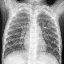

In [9]:
# check out some images to make sure they loaded properly
array_to_img(train_images[791])

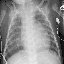

In [10]:
array_to_img(train_images[0])

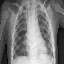

In [11]:
array_to_img(test_images[0])

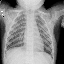

In [12]:
array_to_img(val_images[0])

In [13]:
# look at the shapes
print(f"train images: {train_images.shape}")
print(f"train labels: {train_labels.shape}")
print(f"test images: {test_images.shape}")
print(f"test labels: {test_labels.shape}")
print(f"val images: {val_images.shape}")
print(f"val labels: {val_labels.shape}")

train images: (5216, 64, 64, 3)
train labels: (5216, 2)
test images: (624, 64, 64, 3)
test labels: (624, 2)
val images: (16, 64, 64, 3)
val labels: (16, 2)


The labels each have shape (x, 2) implying it's multiclass. This is a binary classification (it's either pneumonia or normal) so we need to change the shape to be (x, 1). So change output from [0,1] or [1,0] to be either 0 or 1.

In [14]:
# look at what each data set is classifying as normal vs pneumonia
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Change the labels from multi to binary

In [104]:
# train_labels.T[0] selects the first row of the transposed matrix. Should correspond to normal.
# train_labels.T[1] selects the second row of the transposed matrix. should correspond to pneumonia.
# using train_labels.T[0] swaps the results. 
# so use train_labels.T[1]

train_labels_final = train_labels.T[1]
test_labels_final = test_labels.T[1]
val_labels_final = val_labels.T[1]

print(f"train labels updated shape: {train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

train labels updated shape: (5216,)
test labels updated shape: (624,)
val labels updated shape: (16,)


In [105]:
print(f"original train labels shape: {train_labels.shape}")
print(f"updated train labels shape: {train_labels_final.shape}")

original train labels shape: (5216, 2)
updated train labels shape: (5216,)


Check it out: first look at some normal images to see if they look correct. 

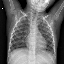

In [117]:
array_to_img(train_images[240])

In [118]:
train_labels_final[240]

0.0

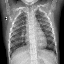

In [119]:
array_to_img(train_images[390])

In [120]:
train_labels_final[390]

0.0

Now look at some pneumonia images to see if they look correct. 

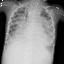

In [121]:
array_to_img(train_images[11])

In [122]:
# pneumonia
train_labels_final[11]

1.0

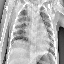

In [123]:
array_to_img(train_images[7])

In [124]:
train_labels_final[7]

1.0

Visually inspecting, this looks accurate. 

first model:

In [131]:
# create the convolutional base
# can use any activation that makes sense
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid')) # sigmoid class, softmax multiclass

In [132]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 53825     
Total params: 73,217
Trainable params: 73,217
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.compile(optimizer='adam', # pick any that make sense
              loss='binary_crossentropy', # look at loss functions, can use binary cross entropy once labels are fixed
              metrics=['accuracy']) # pick any that make sense

In [134]:
train_images.shape

(5216, 64, 64, 3)

In [135]:
train_labels_final.shape

(5216,)

In [136]:
results = model.fit(train_images, train_labels_final, 
          epochs=25, 
          batch_size=75)

Epoch 1/25
70/70 [==============================] - 13s 181ms/step - loss: 0.3452 - accuracy: 0.8503
Epoch 2/25
70/70 [==============================] - 13s 179ms/step - loss: 0.1157 - accuracy: 0.9546
Epoch 3/25
70/70 [==============================] - 12s 171ms/step - loss: 0.0915 - accuracy: 0.9668
Epoch 4/25
70/70 [==============================] - 13s 181ms/step - loss: 0.0791 - accuracy: 0.9699
Epoch 5/25
70/70 [==============================] - 13s 188ms/step - loss: 0.0678 - accuracy: 0.9734
Epoch 6/25
70/70 [==============================] - 13s 192ms/step - loss: 0.0718 - accuracy: 0.9720s - loss: 0.072
Epoch 7/25
70/70 [==============================] - 13s 188ms/step - loss: 0.0612 - accuracy: 0.9764
Epoch 8/25
70/70 [==============================] - 13s 186ms/step - loss: 0.0584 - accuracy: 0.9808
Epoch 9/25
70/70 [==============================] - 13s 187ms/step - loss: 0.0442 - accuracy: 0.9852
Epoch 10/25
70/70 [==============================] - 12s 175ms/step - loss: 

In [137]:
train_loss, train_acc = model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 5s 30ms/step - loss: 0.0016 - accuracy: 1.0000 0s - loss: 0.0016 - accuracy:  - ETA: 0s - loss: 0.0016 - accuracy: 


In [138]:
test_loss, test_acc = model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 31ms/step - loss: 2.3813 - accuracy: 0.7468


Yep, super overfit.

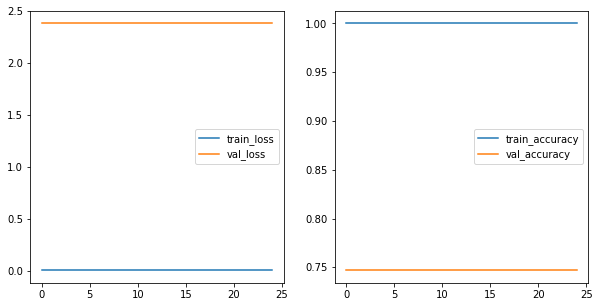

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=test_acc, ax=ax2, label='val_accuracy');